This notebook contains the code for creating the validation plot depicted in the documentation chapter denominated as "Validation of `PeakPerformance`" from the processed data of test 1 and raw data of tests 2 and 3.  
For the data processing of test 1, the reader is referred to the `Processing test 1 raw data` notebook.  
The raw data files are located within the `PeakPerformance` repository under `/docs/source/notebooks`.

In [1]:
%load_ext autoreload
%autoreload 2

import arviz as az
import json
import numpy as np
import pandas
import pymc as pm
from matplotlib import pyplot as plt
from pathlib import Path

#### 1) Preparation of evaluation of synthetic data (test 1)

In [2]:
with open('test1_all_data.txt', 'r') as file:
    all_data = json.loads(file.read())

#### 2) Prepartion of border-line cases normal vs. skew normal (test 2)

In [3]:
df = pandas.read_excel("test2_summary.xlsx")
df_normal = df[(df.loc[:, "model"] == "normal") & (df.loc[:, "Unnamed: 0"].isin(["area", "height"]))]
df_normal.reset_index(inplace=True)
df_skew = df[(df.loc[:, "model"] == "skew_normal") & (df.loc[:, "Unnamed: 0"].isin(["area", "height"]))]
df_skew.reset_index(inplace=True)
df_comparison = pandas.DataFrame()
df_comparison.loc[:, "ratio_mean_normal_to_skew"] = df_normal.loc[:, "mean"] / df_skew.loc[:, "mean"]
df_comparison["ratio_sd_normal_to_skew"] = df_normal["sd"] / df_skew["sd"]
df_comparison["parameter"] = df_normal["Unnamed: 0"]
df_comparison["test_iteration"] = df_normal["test_iteration"]
df_comparison_area = df_comparison[df_comparison["parameter"] == "area"]
df_comparison_height = df_comparison[df_comparison["parameter"] == "height"]
comparison_dict = {}
comparison_dict["fraction of mean (normal / skew normal)"] = [[df_comparison_area["ratio_mean_normal_to_skew"].mean(), df_comparison_height["ratio_mean_normal_to_skew"].mean()], [df_comparison_area["ratio_mean_normal_to_skew"].std(), df_comparison_height["ratio_mean_normal_to_skew"].std()]]
comparison_dict["fraction of standard deviation (normal / skew normal)"] = [[df_comparison_area["ratio_sd_normal_to_skew"].mean(), df_comparison_height["ratio_sd_normal_to_skew"].mean()], [df_comparison_area["ratio_sd_normal_to_skew"].std(), df_comparison_height["ratio_sd_normal_to_skew"].std()]]

#### 3) Prepartion of comparison to MultiQuant (test 3)

In [4]:
df_comparison_total = pandas.read_excel("test3_df_comparison.xlsx")
df_comparison_single = df_comparison_total[~df_comparison_total["PP experiment"].isin([23, 24])]
df_comparison_double = df_comparison_total[df_comparison_total["PP experiment"].isin([23, 24])]

#### 4) Plotting in one graph (for PeakPerformance paper)

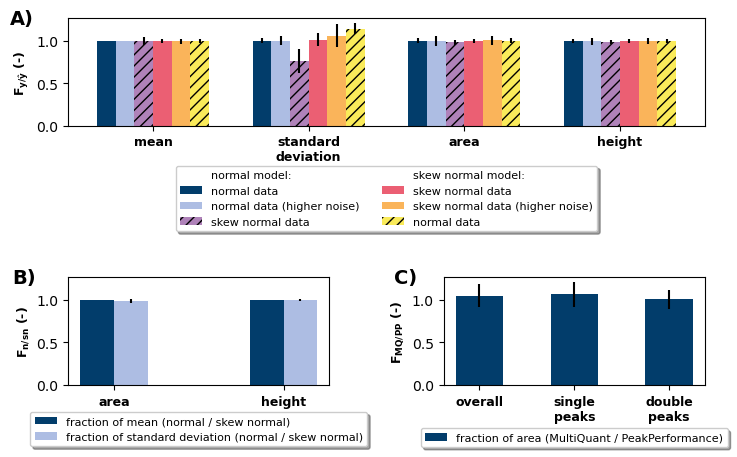

In [5]:
fig = plt.figure(figsize=(7.5, 4.8))
ax1= fig.add_subplot(2,1,1)
ax2= fig.add_subplot(2,2,3)
ax3= fig.add_subplot(2,2,4)
# moving the lower graphs down to create space for the legend
pos1 = ax1.get_position()
ax1.set_position([pos1.x0, pos1.y0-0.08, pos1.width, pos1.height])

# add a - c to the graphs
ax1.text(-0.62, 1.2, "A)", fontsize=14, fontweight="bold")
ax2.text(-0.5, 1.2, "B)", fontsize=14, fontweight="bold")
ax3.text(-0.9, 1.2, "C)", fontsize=14, fontweight="bold")

# graph 1
params = ['mean', 'std', 'area', 'height']
x = np.arange(len(params))  # the label locations
width = 0.12  # the width of the bars
colors = [
    ("#023d6b"), # Jülich dark blue
    ("#adbde3"), # Jülich light blue
    ("#af82b9"), # Jülich hyancith violet
    ("#eb5f73"), # Jülich raspberry
    ("#fab45a"), # Jülich apricot
    ("#faeb5a"), # Jülich lemon
]
multiplier = 0
for metric, result in all_data.items():
    offset = width * multiplier
    if metric in ["skew normal data, normal model", "normal data, skew normal model"]:
        rects = ax1.bar(x + offset, result[0], width, label=metric, yerr=result[1], color=colors[multiplier], hatch="///")
    else:
        rects = ax1.bar(x + offset, result[0], width, label=metric, yerr=result[1], color=colors[multiplier])
    multiplier += 1   
ax1.set_ylabel(r"$\bf{F_{y / \^y}}}$ (-)", fontsize=9, fontweight="bold")
box = ax1.get_position()
# legend below
h, l = ax1.get_legend_handles_labels()
ph = [ax1.plot([],marker="", ls="")[0]]*2
handles = ph[:1] + h[:3] + ph[1:] + h[3:]
# labels = ["normal model:"] + l[:3] + ["skew normal model:"] + l[3:]
labels = ["normal model:", "normal data", "normal data (higher noise)", "skew normal data","skew normal model:", "skew normal data", "skew normal data (higher noise)", "normal data"]
order = []
leg = plt.legend(handles, labels, ncol=2)
for vpack in leg._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

ax1.set_position([box.x0, box.y0 + box.height * 0.15, box.width, box.height * 0.85])
ax1.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.32), fancybox=True, shadow=True, ncol=2, fontsize=8)
# legend on the right
# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, ncol=1)
params = [x if not x == "baseline_intercept" else "baseline\nintercept" for x in params]
params = [x if not x == "baseline_slope" else "baseline\nslope" for x in params]
params = [x if not x == "std" else "standard\ndeviation" for x in params]
ax1.set_xticks(x + 2.5 * width, params, fontsize=9, fontweight="bold")

# graph 2
params = ["area", "height"]
x = np.arange(len(params))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
for metric, result in comparison_dict.items():
    offset = width * multiplier
    rects = ax2.bar(x + offset, result[0], width, label=metric, yerr=result[1], color=colors[multiplier])
    multiplier += 1   
ax2.set_ylabel(r"$\bf{F_{n / sn}}}$ (-)", fontsize=9, fontweight="bold")
box = ax2.get_position()
# legend below
# ax2.set_position([box.x0, box.y0 + box.height * 0.15, box.width, box.height * 0.85])
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1, fontsize=8)
# legend on the right
# ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True, ncol=1)
params = [x if not x == "baseline_intercept" else "baseline\nintercept" for x in params]
params = [x if not x == "baseline_slope" else "baseline\nslope" for x in params]
params = [x if not x == "std" else "standard\ndeviation" for x in params]
ax2.set_xticks(x + 0.5 * width, params, fontsize=9, fontweight="bold")
ax2.set_ylim(0.0, 1.264356410280364)

# graph 3
categories = ["overall", "single\npeaks", "double\npeaks"]
means = [
    df_comparison_total["area MQ / PP"].mean(), 
    df_comparison_single["area MQ / PP"].mean(),
    df_comparison_double["area MQ / PP"].mean(),
]
sds = [
    df_comparison_total["area MQ / PP"].std(),
    df_comparison_single["area MQ / PP"].std(),
    df_comparison_double["area MQ / PP"].std(),
]
ax3.bar(
    x=categories,
    width=0.5,
    height=means,
    yerr=sds,
    color=("#023d6b"), # Jülich dark blue
    label="fraction of area (MultiQuant / PeakPerformance)",
)
ax3.set_ylabel(r"$\bf{F_{MQ / PP}}}$ (-)", fontsize=9, fontweight="bold")
ax3.set_xticks(np.arange(len(categories)), categories, fontsize=9, fontweight="bold")
ax3.legend(loc="upper center", bbox_to_anchor=(0.5, -0.35), fancybox=True, shadow=True, ncol=1, fontsize=8)

fig.tight_layout()
plt.show()

In [6]:
%load_ext watermark
%watermark -idu

Last updated: 2024-10-11T17:56:34.996952+02:00

